In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import math

In [2]:
def initialize_parameters(layer_dims):
    parameters = {}
    L = len(layer_dims)
    for l in range(1,L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros([layer_dims[l], 1])
    return parameters

In [3]:
def relu(Z):
    A = np.maximum(0,Z)
    caches = Z
    return A, caches
def softmax(Z):
    A = np.exp(Z) / np.sum(np.exp(Z), axis = 0)
    caches = Z
    return A, caches
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    caches = Z
    return A, caches

In [4]:
def model_activation_forward(A_prev, W, b, activation):
    linear_cache = (A_prev, W, b)
    Z = np.dot(W, A_prev) + b
    if activation == 'relu':
        A, activation_cache = relu(Z)
    elif activation == 'softmax':
        A, activation_cache = softmax(Z)
    caches = (linear_cache, activation_cache)
    return A, caches        

In [5]:
def model_forward(X, parameters):
    caches = [];
    A_prev= X
    L = len(parameters)//2
    for l in range(1,L):
        A, cache = model_activation_forward(A_prev, parameters['W' + str(l)],parameters['b' + str(l)], activation = 'relu')
        A_prev = A 
        caches.append(cache)
    AL, cache = model_activation_forward(A_prev, parameters['W' + str(L)], parameters['b' + str(L)], activation = 'softmax')
    caches.append(cache)
    return AL, caches

In [6]:
def compute_cost(Y, AL):
    m = AL.shape[1]
    tmpAL = np.maximum(AL, 1.0e-15)  
    cost = (-1./m) * (np.sum(np.multiply(Y, np.log(tmpAL))) + np.sum(np.multiply(1-Y, np.log(1-tmpAL))))
    cost = np.squeeze(cost) # to remove single dimensional entries in shape of array
    return cost

In [7]:
def relu_derivative(dA, cache):
    Z = cache
    dZ = np.array(dA, copy = True)
    dZ[Z<=0] = 0
    return dZ
def sigmoid_derivative(dA, cache):
    Z = cache
    s, temp = sigmoid(Z) 
    derivative = s * (1 - s)
    dZ = np.multiply(dA, derivative)
    return dZ

In [8]:
def model_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == 'relu':
        dZ = relu_derivative(dA, activation_cache)
    elif activation == 'softmax':
        dZ = dA #dZ value is passed as parameter
    A_prev, W, b = linear_cache    
    m = A_prev.shape[1]
    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis =1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

In [9]:
def model_backward(AL, Y, caches):
    grads = {}
    m = AL.shape[1]
    L = len(caches) #np. of layers
    dZ = AL - Y
    current_cache = caches[L-1]
    grads['dA' + str(L-1)], grads['dW' + str(L)], grads['db' + str(L)] = model_activation_backward(dZ, current_cache, activation ='softmax')
    #Looping frm L-2 to 0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev, dW_temp, db_temp = model_activation_backward(grads['dA' + str(l+1)], current_cache, activation = 'relu')
        grads['dA' + str(l)] = dA_prev
        grads['dW' + str(l+1)] = dW_temp
        grads['db' + str(l+1)] = db_temp
    return grads

In [10]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters)//2
    for l in range(L):
        parameters['W' + str(l+1)] = parameters['W' + str(l+1)] - learning_rate*grads['dW' + str(l+1)]
        parameters['b' + str(l+1)] = parameters['b' + str(l+1)] - learning_rate*grads['db' + str(l+1)]
    return parameters

In [127]:
def mini_batches(X, Y, minibatch_size = 40):
    m = X.shape[1]
    mini_batches = []
    shuffle = list(np.random.permutation(m))
    X_shuffle = X[:, shuffle]
    Y_shuffle = Y[:, shuffle]
    
    complete_minibatch = math.floor(m/minibatch_size)
    for i in range(0, complete_minibatch):
        minibatch_X = X[:, (i*minibatch_size):(i+1)*minibatch_size]
        minibatch_Y = Y[:, (i*minibatch_size):(i+1)*minibatch_size]
        minibatch = (minibatch_X, minibatch_Y)
        mini_batches.append(minibatch)
    
    if(m % minibatch_size != 0 ):
        minibatch_X = X[:, (complete_minibatch*minibatch_size):]
        minibatch_Y = Y[:, (complete_minibatch*minibatch_size):]
        minibatch = (minibatch_X, minibatch_Y)
        mini_batches.append(minibatch)
    return mini_batches

In [12]:
def L_layer_model(X, Y, layer_dims, learning_rate = 0.0075, num_iterations = 300, print_cost = False):
    costs = []
    parameters = initialize_parameters(layer_dims)
    for i in range(num_iterations):
        AL, caches = model_forward(X, parameters)
        cost = compute_cost(Y, AL)
        grads = model_backward(AL, Y,caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i%100 == 0:
            print('Cost after iteration %i: %f' %(i,cost))
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return parameters

In [13]:
def L_layer_model_with_mb(X, Y, layer_dims, learning_rate = 0.0075, num_epochs = 100, minibatch_size = 1000, print_cost = False):
    costs = []
    parameters = initialize_parameters(layer_dims)
    for i in range(0, num_epochs):
        minibatches = mini_batches(X, Y, minibatch_size = minibatch_size)
        for minbatch in minibatches:
            (mini_batch_X, mini_batch_Y) = minbatch
            AL, caches = model_forward(mini_batch_X, parameters)
            cost = compute_cost(mini_batch_Y, AL)
            grads = model_backward(AL, mini_batch_Y,caches)
            parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i%100 == 0:
            print('Cost after epoch %i: %f' %(i,cost))
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return parameters

In [36]:
def predict(X, parameters):
    probab, cache = model_forward(X, parameters)
    p = np.zeros(probab.shape)
    tmp_pred = np.argmax(probab, axis = 0)
    p[tmp_pred, np.arange(len(tmp_pred))] = 1
    return p
def predict_accuracy(X, Y, parameters):
    p = predict(X, parameters)
    m = X.shape[1]
    tmp_p = p.astype(bool)
    tmp_y = Y.astype(bool)
    accuracy = np.sum((tmp_p & tmp_y)/m)
    print('Accurancy: ' + str(accuracy))
    return accuracy, p        

In [56]:
train = pd.read_csv(r'E:\Datasets\digit\train.csv')
test = pd.read_csv(r'E:\Datasets\digit\test.csv')
train.shape, test.shape

((42000, 785), (28000, 784))

In [59]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
X = train.drop('label', axis = 1)
Y = train['label']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 21)

In [75]:
def split_data(X, Y):
    #Splitting out independent variables
    X_array = np.array(X.values).T
    Y_array = np.array(Y.values)
    Y_array = Y_array.reshape(-1,1)
    onehotencoder = OneHotEncoder()
    Y_array = onehotencoder.fit_transform(Y_array).toarray()
    Y_array = Y_array.T
    return X_array, Y_array

In [76]:
train_X, train_Y = split_data(X_train, Y_train)
test_X, test_Y = split_data(X_test, Y_test)

In [78]:
train_X.shape, train_Y.shape

((784, 29400), (10, 29400))

Cost after iteration 0: 3.249040
Cost after iteration 100: 1.423674
Cost after iteration 200: 0.677233
Cost after iteration 300: 0.492647
Cost after iteration 400: 0.413777
Cost after iteration 500: 0.376636
Cost after iteration 600: 0.330410
Cost after iteration 700: 0.318224
Cost after iteration 800: 0.284044
Cost after iteration 900: 0.263283
Cost after iteration 1000: 0.246366
Cost after iteration 1100: 0.346787
Cost after iteration 1200: 0.236299
Cost after iteration 1300: 0.216643
Cost after iteration 1400: 0.205169
Cost after iteration 1500: 0.199512


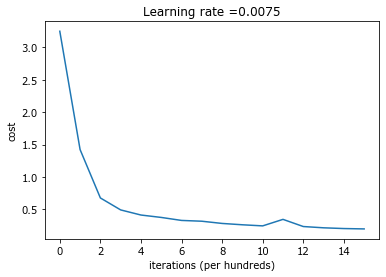

In [142]:
layer_dims = [784, 16, 16, 10]
parameters = L_layer_model(train_X, train_Y, layer_dims, learning_rate = 0.0075, num_iterations = 1600, print_cost = True)

In [143]:
prob = np.zeros(test_X.shape)
predictions_train, prob = predict_accuracy(test_X, test_Y, parameters)
label_pred = np.reshape(np.argmax(prob, axis = 0), (1,-1))

Accurancy: 0.9462698412698414


In [82]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
test = np.array(test.values).T
test.shape

(784, 28000)

In [144]:
test_y = predict(test, parameters)
label_test_pred = np.reshape(np.argmax(test_y, axis = 0), (1,-1))

In [85]:
label_test_pred[:, :10]

array([[2, 0, 9, 9, 3, 7, 0, 3, 0, 3]], dtype=int64)

In [115]:
def create_submission(prediction):
    df = pd.DataFrame(prediction.T)
    df.index += 1
    df.index.names = ['ImageId']
    df.columns = ['Label']
    df.to_csv(r'E:\Datasets\digit\submission.csv', index=True)
    return df

Cost after epoch 0: 3.230382
Cost after epoch 100: 0.140666
Cost after epoch 200: 0.074864


C:\Users\Sathish Kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Sathish Kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Cost after epoch 300: 0.161098
Cost after epoch 400: 0.063093
Cost after epoch 500: 0.275273
Cost after epoch 600: nan
Cost after epoch 700: 0.074362
Cost after epoch 800: 0.058962
Cost after epoch 900: 0.078468


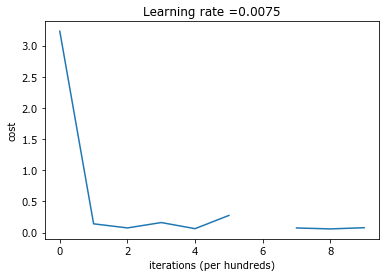

In [128]:
#Using mini-batches
layer_dims = [784, 16, 16, 10]
parameters1 = L_layer_model_with_mb(train_X, train_Y, layer_dims, learning_rate = 0.0075, num_epochs = 1000, print_cost = True)

In [132]:
prob1 = np.zeros(test_X.shape)
predictions_train1, prob1 = predict_accuracy(test_X, test_Y, parameters1)

Accurancy: 0.9300793650793652


In [145]:
test_y = predict(test, parameters1)
label_test_pred = np.reshape(np.argmax(test_y, axis = 0), (1,-1))
df = create_submission(label_test_pred)